In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm,trange
import cv2
import time
import os
from PIL import Image
import glob as gb
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from sklearn.model_selection import train_test_split
BATCH_SIZE = 32
torch.manual_seed(17)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
datapath="/kaggle/input/satellite-image-classification/data/"
label_names = ["cloudy","desert","green_area","water"]

# 1. Loading and showing data

In [2]:
def loaddata(dataset,label_names):

    images=[]
    labels=[]
    t=[]
    for folder in os.listdir(dataset):
        print("Load data from {}".format(folder))
        files=gb.glob(pathname=str(dataset+folder+"/*.jpg"))
        
        label = label_names.index(folder)
        for file in tqdm(files):
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (64,64))
            images.append(Image.fromarray(image))
            labels.append(label)

    return images,labels

In [3]:
train_tran = transforms.Compose([
                    transforms.RandomRotation(5),
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.RandomCrop(64, padding=2),
                    transforms.ToTensor(),
                ])
tran = transforms.Compose([
                    transforms.ToTensor(),
                ])

In [4]:
class SatalliteDataset(Dataset):
    def __init__(self,images,labels, is_train):
        self.images_list=images
        self.labels_list=labels
        self.is_train=is_train
    
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self,idx):
        if self.is_train:
            return train_tran(self.images_list[idx]).to(device), self.labels_list[idx]
        return tran(self.images_list[idx]).to(device), self.labels_list[idx]

In [5]:
images,labels = loaddata(datapath,label_names)
images,labels = shuffle(images,labels, random_state=64)


X_train, X_Test, y_train, y_Test = train_test_split(images,labels, test_size=0.23, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_Test, y_Test, test_size=0.23, random_state=42)

train_iterator = data.DataLoader(SatalliteDataset(X_train,y_train, True),
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(SatalliteDataset(X_test,y_test, False),
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(SatalliteDataset(X_val,y_val, False),
                                batch_size=BATCH_SIZE)

Load data from cloudy


  0%|          | 0/1500 [00:00<?, ?it/s]

Load data from desert


  0%|          | 0/1131 [00:00<?, ?it/s]

Load data from green_area


  0%|          | 0/1500 [00:00<?, ?it/s]

Load data from water


  0%|          | 0/1500 [00:00<?, ?it/s]

In [6]:
def plot_images(normalize=False):
    dataset="/kaggle/input/satellite-image-classification/data/"
    label_names = ["cloudy","desert","green_area","water"]
    
    fig = plt.figure(figsize=(10, 10))
    
    n=1
    for i in range(5):
        for label in label_names:
            ax = fig.add_subplot(5, 4, n)
            n+=1
            
            image=cv2.cvtColor(
                cv2.imread(
                    os.path.join(
                        dataset,
                        label,
                        os.listdir(os.path.join(dataset,label))[i]
                    )), 
                cv2.COLOR_BGR2RGB
            )
            
            if normalize:
                image_min = image.min()
                image_max = image.max()
                image=image-image_min
                image=image/(image_max-image_min)
            ax.imshow(image)
            ax.set_title(label)
            ax.axis('off')

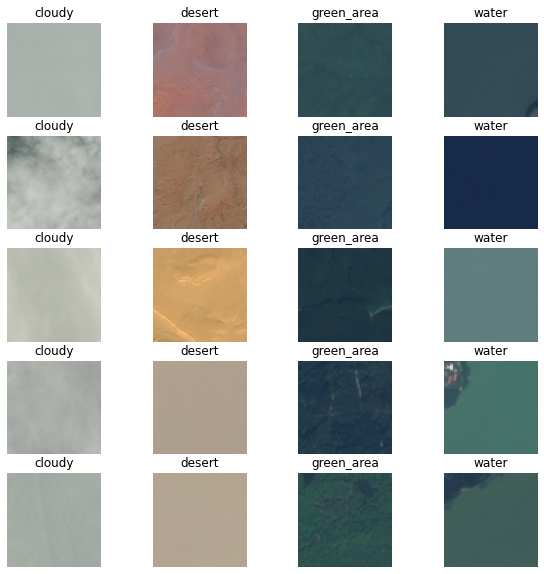

In [7]:
plot_images()

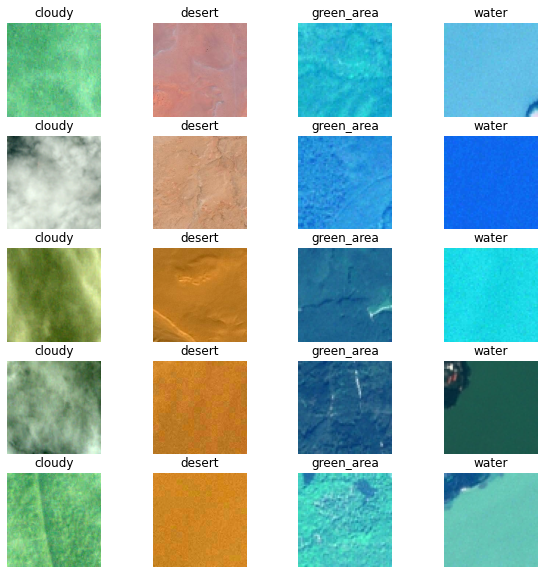

In [8]:
plot_images(True)

# Model training

In [9]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  
            nn.MaxPool2d(2),  
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [10]:
OUTPUT_DIM = 4

model = AlexNet(OUTPUT_DIM)
model = model.to(device)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 35,830,596 trainable parameters


In [12]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [13]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [14]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)
        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [15]:
START_LR = 1e-7
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=START_LR)


criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [16]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [17]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

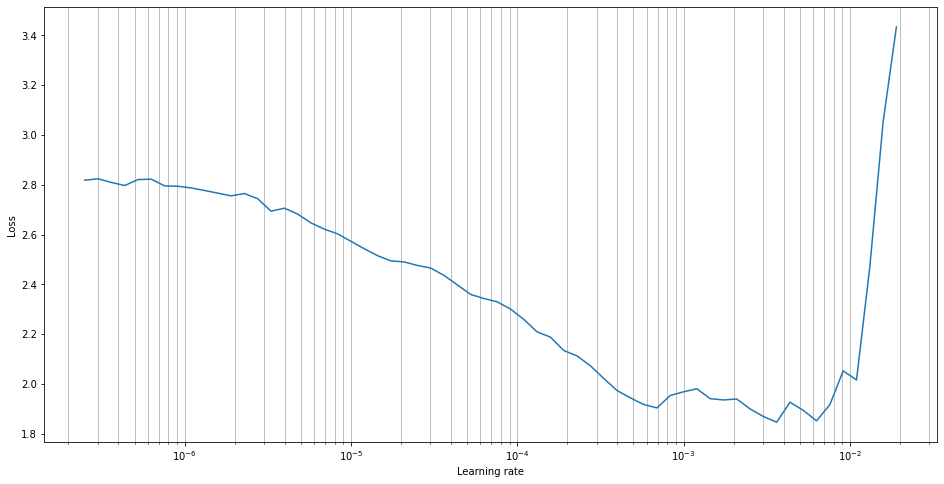

In [18]:
plot_lr_finder(lrs, losses)

In [19]:
FOUND_LR = 1e-4

optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)

In [20]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [21]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
EPOCHS = 25

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.734 | Train Acc: 66.52%
	 Val. Loss: 0.396 |  Val. Acc: 84.77%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.428 | Train Acc: 81.56%
	 Val. Loss: 0.336 |  Val. Acc: 88.84%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.376 | Train Acc: 84.57%
	 Val. Loss: 0.350 |  Val. Acc: 84.15%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.313 | Train Acc: 87.65%
	 Val. Loss: 0.219 |  Val. Acc: 91.90%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.296 | Train Acc: 87.63%
	 Val. Loss: 0.272 |  Val. Acc: 88.47%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.246 | Train Acc: 90.25%
	 Val. Loss: 0.241 |  Val. Acc: 88.49%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.244 | Train Acc: 90.06%
	 Val. Loss: 0.237 |  Val. Acc: 89.74%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.225 | Train Acc: 91.05%
	 Val. Loss: 0.229 |  Val. Acc: 90.34%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.204 | Train Acc: 91.95%
	 Val. Loss: 0.209 |  Val. Acc: 89.74%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 5s
	Train Loss: 0.188 | Train Acc: 92.82%
	 Val. Loss: 0.179 |  Val. Acc: 92.84%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 5s
	Train Loss: 0.173 | Train Acc: 93.49%
	 Val. Loss: 0.160 |  Val. Acc: 93.78%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 5s
	Train Loss: 0.176 | Train Acc: 93.28%
	 Val. Loss: 0.164 |  Val. Acc: 93.47%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 5s
	Train Loss: 0.179 | Train Acc: 93.03%
	 Val. Loss: 0.194 |  Val. Acc: 91.62%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 5s
	Train Loss: 0.164 | Train Acc: 93.81%
	 Val. Loss: 0.168 |  Val. Acc: 93.15%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 5s
	Train Loss: 0.176 | Train Acc: 93.26%
	 Val. Loss: 0.236 |  Val. Acc: 91.28%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 6s
	Train Loss: 0.164 | Train Acc: 93.58%
	 Val. Loss: 0.159 |  Val. Acc: 94.09%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 5s
	Train Loss: 0.154 | Train Acc: 93.81%
	 Val. Loss: 0.171 |  Val. Acc: 91.59%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 6s
	Train Loss: 0.164 | Train Acc: 93.35%
	 Val. Loss: 0.148 |  Val. Acc: 94.09%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 5s
	Train Loss: 0.151 | Train Acc: 94.02%
	 Val. Loss: 0.130 |  Val. Acc: 95.03%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 5s
	Train Loss: 0.148 | Train Acc: 94.36%
	 Val. Loss: 0.161 |  Val. Acc: 93.49%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 5s
	Train Loss: 0.136 | Train Acc: 94.57%
	 Val. Loss: 0.162 |  Val. Acc: 92.22%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 5s
	Train Loss: 0.154 | Train Acc: 93.90%
	 Val. Loss: 0.153 |  Val. Acc: 95.31%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 5s
	Train Loss: 0.141 | Train Acc: 94.34%
	 Val. Loss: 0.209 |  Val. Acc: 92.24%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 6s
	Train Loss: 0.132 | Train Acc: 95.03%
	 Val. Loss: 0.126 |  Val. Acc: 94.72%


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 5s
	Train Loss: 0.136 | Train Acc: 94.73%
	 Val. Loss: 0.126 |  Val. Acc: 95.97%


In [25]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 0.115 | Test Acc: 96.05%


In [26]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [27]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [28]:
pred_labels = torch.argmax(probs, 1)

In [29]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(4, 1))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

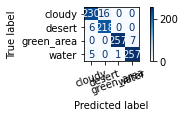

In [30]:
classes = ["cloudy","desert","green_area","water"]
plot_confusion_matrix(labels, pred_labels, classes)